In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(4120)

# Define date range
start_date = datetime(2021, 1, 1)
end_date = datetime(2025, 12, 31)

# Generate date range with daily frequency
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Generate random sales data
# Using a combination of base sales + trend + seasonality + random noise
n_days = len(date_range)

# Base sales around 1000 units
base_sales = 1000

# Add trend component (slight upward trend over time)
trend = np.linspace(0, 200, n_days)

# Add seasonal component (yearly cycle)
seasonal = 150 * np.sin(2 * np.pi * np.arange(n_days) / 365.25)

# Add weekly pattern (higher sales on weekends)
day_of_week = pd.Series(date_range).dt.dayofweek
weekly_pattern = np.where(day_of_week.isin([5, 6]), 100, 0)  # Weekend boost

# Add random noise
noise = np.random.normal(0, 50, n_days)

# Combine all components
sales = base_sales + trend + seasonal + weekly_pattern + noise

# Ensure sales are positive
sales = np.maximum(sales, 0)

# Round to nearest integer
sales = np.round(sales).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'date': date_range,
    'sales': sales
})

# Display first and last few rows
print("Dataset created successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst 10 rows:")
print(df.head(10))
print(f"\nLast 10 rows:")
print(df.tail(10))

# Basic statistics
print(f"\nBasic Statistics:")
print(df['sales'].describe())

# Save to CSV file
csv_filename = 'sales_data_2023_2025_v3.csv'
df.to_csv(csv_filename, index=False)
print(f"\nDataset saved to '{csv_filename}'")





Dataset created successfully!

Dataset shape: (1826, 2)
Date range: 2021-01-01 00:00:00 to 2025-12-31 00:00:00

First 10 rows:
        date  sales
0 2021-01-01    941
1 2021-01-02   1157
2 2021-01-03   1149
3 2021-01-04    944
4 2021-01-05   1071
5 2021-01-06   1062
6 2021-01-07   1047
7 2021-01-08   1078
8 2021-01-09   1110
9 2021-01-10   1141

Last 10 rows:
           date  sales
1816 2025-12-22   1236
1817 2025-12-23   1177
1818 2025-12-24   1227
1819 2025-12-25   1203
1820 2025-12-26   1157
1821 2025-12-27   1291
1822 2025-12-28   1294
1823 2025-12-29   1156
1824 2025-12-30   1153
1825 2025-12-31   1182

Basic Statistics:
count    1826.000000
mean     1130.065170
std       131.149178
min       798.000000
25%      1033.000000
50%      1128.000000
75%      1229.000000
max      1518.000000
Name: sales, dtype: float64

Dataset saved to 'sales_data_2023_2025_v3.csv'


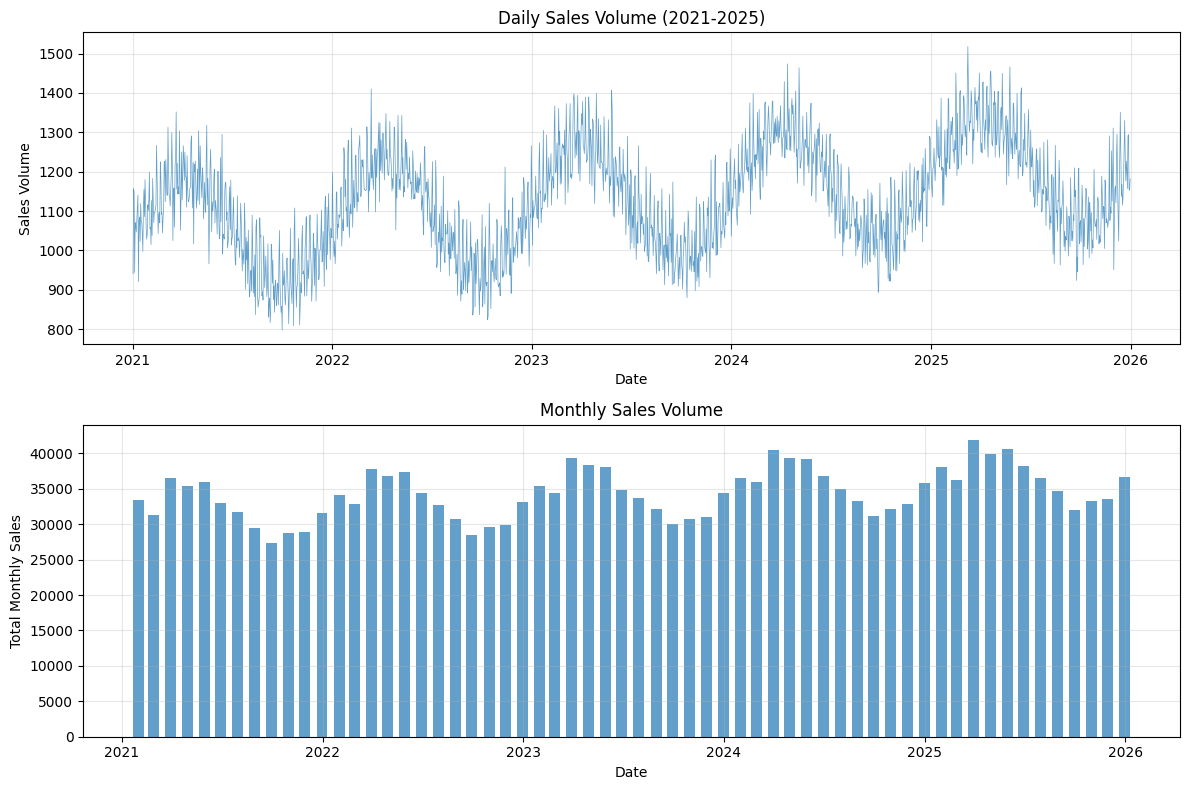


Visualization saved to 'sales_visualization_v3.png'


In [3]:
# Create a simple visualization
try:
    import matplotlib.pyplot as plt
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Full time series
    axes[0].plot(df['date'], df['sales'], linewidth=0.5, alpha=0.7)
    axes[0].set_title('Daily Sales Volume (2021-2025)')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Sales Volume')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Monthly aggregated sales
    df_monthly = df.set_index('date').resample('ME')['sales'].sum().reset_index()
    axes[1].bar(df_monthly['date'], df_monthly['sales'], width=20, alpha=0.7)
    axes[1].set_title('Monthly Sales Volume')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Total Monthly Sales')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sales_visualization_v3.png', dpi=100)
    plt.show()
    print("\nVisualization saved to 'sales_visualization_v3.png'")
    
except ImportError:
    print("\nNote: Install matplotlib for visualization (pip install matplotlib)")

In [4]:
import mlflow
import mlflow.prophet
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from dotenv import load_dotenv
import datetime
# Load environment variables from .env file
load_dotenv()


experiment_name = "/Users/j.huertas@closerstillmedia.com/prophet"
try:
    mlflow.create_experiment(experiment_name)
except:
    print("experiment exists")
mlflow.set_experiment(experiment_name)

experiment exists


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3039328626124250', creation_time=1755624146266, experiment_id='3039328626124250', last_update_time=1755630940708, lifecycle_stage='active', name='/Users/j.huertas@closerstillmedia.com/prophet', tags={'mlflow.databricks.filesystem.experiment_permissions_check': 'test',
 'mlflow.experiment.sourceName': '/Users/j.huertas@closerstillmedia.com/prophet',
 'mlflow.experimentKind': 'custom_model_development',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'b.relf@closerstillmedia.com',
 'mlflow.ownerId': '7931383772120950'}>

In [5]:
def prepare_prophet_data(data, date_col, value_col, freq="D"):
    """
    Prepare data for Prophet training.

    Args:
        data: DataFrame with time series data
        date_col: Name of date column
        value_col: Name of value column
        freq: Frequency of the time series
    """

    # Prophet requires columns named 'ds' (datestamp) and 'y' (value)
    prophet_df = data[[date_col, value_col]].copy()
    prophet_df.columns = ["ds", "y"]

    # Ensure ds is datetime
    prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

    # Sort by date
    prophet_df = prophet_df.sort_values("ds").reset_index(drop=True)

    # Handle missing dates if needed
    if freq:
        full_date_range = pd.date_range(
            start=prophet_df["ds"].min(), end=prophet_df["ds"].max(), freq=freq
        )

        # Reindex to fill missing dates
        prophet_df = prophet_df.set_index("ds").reindex(full_date_range).reset_index()
        prophet_df.columns = ["ds", "y"]

        # Log data quality metrics
        missing_dates = prophet_df["y"].isna().sum()
        print(f"Missing dates filled: {missing_dates}")

    return prophet_df

    
df_prepared = prepare_prophet_data(df, 'date', 'sales', freq='D')
df_prepared.head()

Missing dates filled: 0


,ds,y
0,2021-01-01,941
1,2021-01-02,1157
2,2021-01-03,1149
3,2021-01-04,944
4,2021-01-05,1071


# Systematic Parameter Tuning


In [7]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error


def optimize_prophet_hyperparameters(df, param_grid=None):
    """Systematic hyperparameter optimization for Prophet."""

    if param_grid is None:
        param_grid = {
            "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
            "seasonality_prior_scale": [0.01, 0.1, 1.0, 10.0],
            "holidays_prior_scale": [0.01, 0.1, 1.0, 10.0],
            "seasonality_mode": ["additive", "multiplicative"],
        }

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(itertools.product(*param_values))

    results = []

    with mlflow.start_run(run_name="Prophet Hyperparameter Optimization"):
        mlflow.log_param("total_combinations", len(param_combinations))

        for i, param_combo in enumerate(param_combinations):
            param_dict = dict(zip(param_names, param_combo))

            with mlflow.start_run(run_name=f"Config_{i+1}", nested=True):
                try:
                    # Create model with current parameters
                    model = Prophet(**param_dict)

                    # Time series split for validation
                    train_size = int(len(df) * 0.8)
                    train_df = df.iloc[:train_size]
                    test_df = df.iloc[train_size:]

                    # Fit model
                    model.fit(train_df)

                    # Predict on test set
                    future = model.make_future_dataframe(periods=len(test_df))
                    if model.growth == "logistic":
                        future["cap"] = df["cap"].iloc[-1]

                    forecast = model.predict(future)
                    test_forecast = forecast.iloc[-len(test_df) :]

                    # Calculate metrics
                    mape = mean_absolute_percentage_error(
                        test_df["y"], test_forecast["yhat"]
                    )
                    mae = np.mean(np.abs(test_df["y"] - test_forecast["yhat"]))
                    rmse = np.sqrt(np.mean((test_df["y"] - test_forecast["yhat"]) ** 2))

                    # Log parameters and metrics
                    mlflow.log_params(param_dict)
                    mlflow.log_metrics(
                        {"test_mape": mape, "test_mae": mae, "test_rmse": rmse}
                    )

                    # Store results
                    result = {**param_dict, "mape": mape, "mae": mae, "rmse": rmse}
                    results.append(result)

                    print(f"Config {i+1}/{len(param_combinations)}: MAPE = {mape:.4f}")

                except Exception as e:
                    print(f"Error in configuration {i+1}: {e}")
                    mlflow.log_param("error", str(e))

        # Find best configuration
        best_result = min(results, key=lambda x: x["mape"])

        # Log best configuration
        mlflow.log_params({f"best_{k}": v for k, v in best_result.items()})

        # Train final model with best parameters
        best_params = {
            k: v for k, v in best_result.items() if k not in ["mape", "mae", "rmse"]
        }
        final_model = Prophet(**best_params)
        final_model.fit(df)

        # Log final model
        mlflow.prophet.log_model(
            pr_model=final_model,
            name="best_model",
            input_example=df[["ds"]].head(),
        )

        return final_model, best_result, results


# Usage
best_model, best_config, all_results = optimize_prophet_hyperparameters(df_prepared)

20:29:14 - cmdstanpy - INFO - Chain [1] start processing
20:29:14 - cmdstanpy - INFO - Chain [1] done processing


Config 1/128: MAPE = 0.0331
🏃 View run Config_1 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d93dcb21182e4d1dae89c462e87eba5a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:16 - cmdstanpy - INFO - Chain [1] start processing
20:29:16 - cmdstanpy - INFO - Chain [1] done processing


Config 2/128: MAPE = 0.0332
🏃 View run Config_2 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/ceb7487fdaf641b3ad2a57af08da4a62
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:17 - cmdstanpy - INFO - Chain [1] done processing


Config 3/128: MAPE = 0.0331
🏃 View run Config_3 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d032d2bae2bf43508bb0ad2fbbf76317
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:19 - cmdstanpy - INFO - Chain [1] start processing
20:29:19 - cmdstanpy - INFO - Chain [1] done processing


Config 4/128: MAPE = 0.0332
🏃 View run Config_4 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/239e7da1baa74ce7b08a00412118d7bb
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:20 - cmdstanpy - INFO - Chain [1] start processing
20:29:20 - cmdstanpy - INFO - Chain [1] done processing


Config 5/128: MAPE = 0.0331
🏃 View run Config_5 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/680ed7aa84874534b63985aadf49ec5e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:22 - cmdstanpy - INFO - Chain [1] start processing
20:29:22 - cmdstanpy - INFO - Chain [1] done processing


Config 6/128: MAPE = 0.0332
🏃 View run Config_6 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/30f0df0b908b4b9d830191d40244ac0d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:23 - cmdstanpy - INFO - Chain [1] start processing
20:29:23 - cmdstanpy - INFO - Chain [1] done processing


Config 7/128: MAPE = 0.0331
🏃 View run Config_7 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/c2f8fa9a5c81433e9ff9cc3404e8f081
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:25 - cmdstanpy - INFO - Chain [1] start processing
20:29:25 - cmdstanpy - INFO - Chain [1] done processing


Config 8/128: MAPE = 0.0332
🏃 View run Config_8 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/7cadd7b758b24094a78985320096f63b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:26 - cmdstanpy - INFO - Chain [1] start processing
20:29:26 - cmdstanpy - INFO - Chain [1] done processing


Config 9/128: MAPE = 0.0330
🏃 View run Config_9 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d15ad565e2d8469d9502762e5c64a739
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:28 - cmdstanpy - INFO - Chain [1] start processing
20:29:28 - cmdstanpy - INFO - Chain [1] done processing


Config 10/128: MAPE = 0.0333
🏃 View run Config_10 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/487e83936c1946b7a031b12a0fe3d62d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:29 - cmdstanpy - INFO - Chain [1] start processing
20:29:29 - cmdstanpy - INFO - Chain [1] done processing


Config 11/128: MAPE = 0.0330
🏃 View run Config_11 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/8f4cd39ae58542649d2336e827963f71
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing


Config 12/128: MAPE = 0.0333
🏃 View run Config_12 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/4adda538fbe243aa9e69ba7c3eed9c6a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:32 - cmdstanpy - INFO - Chain [1] start processing
20:29:32 - cmdstanpy - INFO - Chain [1] done processing


Config 13/128: MAPE = 0.0330
🏃 View run Config_13 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/97b7bac89bb64657843ed4a276e68dbf
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:34 - cmdstanpy - INFO - Chain [1] start processing
20:29:34 - cmdstanpy - INFO - Chain [1] done processing


Config 14/128: MAPE = 0.0333
🏃 View run Config_14 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/717e7f0f9a004cb69c554d03582bb4a5
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:35 - cmdstanpy - INFO - Chain [1] start processing
20:29:35 - cmdstanpy - INFO - Chain [1] done processing


Config 15/128: MAPE = 0.0330
🏃 View run Config_15 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/137f8069e6314b13815bf1252e11c4af
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing


Config 16/128: MAPE = 0.0333
🏃 View run Config_16 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/80e0ced7289e463abb4f8943032a20b7
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:38 - cmdstanpy - INFO - Chain [1] start processing
20:29:38 - cmdstanpy - INFO - Chain [1] done processing


Config 17/128: MAPE = 0.0330
🏃 View run Config_17 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/77c01e9c1f6f4412baa8299e591d898b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:40 - cmdstanpy - INFO - Chain [1] start processing
20:29:40 - cmdstanpy - INFO - Chain [1] done processing


Config 18/128: MAPE = 0.0332
🏃 View run Config_18 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/4cb0aed2378d403a9a2d2ef46c1d3dd7
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:41 - cmdstanpy - INFO - Chain [1] start processing
20:29:42 - cmdstanpy - INFO - Chain [1] done processing


Config 19/128: MAPE = 0.0330
🏃 View run Config_19 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/68696bdce1dc42289a67b840f699513c
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:43 - cmdstanpy - INFO - Chain [1] start processing
20:29:43 - cmdstanpy - INFO - Chain [1] done processing


Config 20/128: MAPE = 0.0332
🏃 View run Config_20 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/100856325052414fb522f46f6cd34d3d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:45 - cmdstanpy - INFO - Chain [1] done processing


Config 21/128: MAPE = 0.0330
🏃 View run Config_21 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/83baae606da14efdae8ef1ab97774a79
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:46 - cmdstanpy - INFO - Chain [1] start processing
20:29:46 - cmdstanpy - INFO - Chain [1] done processing


Config 22/128: MAPE = 0.0332
🏃 View run Config_22 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/54c183850c3242bba1f79ba7932e96b9
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:48 - cmdstanpy - INFO - Chain [1] start processing
20:29:48 - cmdstanpy - INFO - Chain [1] done processing


Config 23/128: MAPE = 0.0330
🏃 View run Config_23 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/fedab00e47884feb8c413051afc33de2
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:49 - cmdstanpy - INFO - Chain [1] start processing
20:29:49 - cmdstanpy - INFO - Chain [1] done processing


Config 24/128: MAPE = 0.0332
🏃 View run Config_24 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3c698dc9fe4147468104e7daf553d33d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:51 - cmdstanpy - INFO - Chain [1] start processing
20:29:51 - cmdstanpy - INFO - Chain [1] done processing


Config 25/128: MAPE = 0.0329
🏃 View run Config_25 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a4217fe3134843508df03a743eaaf2cb
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:52 - cmdstanpy - INFO - Chain [1] start processing
20:29:52 - cmdstanpy - INFO - Chain [1] done processing


Config 26/128: MAPE = 0.0334
🏃 View run Config_26 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/30d5b7f2645f4de5be2bbf26a4100713
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:54 - cmdstanpy - INFO - Chain [1] start processing
20:29:54 - cmdstanpy - INFO - Chain [1] done processing


Config 27/128: MAPE = 0.0329
🏃 View run Config_27 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/2d65263597c040318e238418955995fa
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:55 - cmdstanpy - INFO - Chain [1] start processing
20:29:55 - cmdstanpy - INFO - Chain [1] done processing


Config 28/128: MAPE = 0.0334
🏃 View run Config_28 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a7312b3b629c405a867e3825fee8b02f
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing


Config 29/128: MAPE = 0.0329
🏃 View run Config_29 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/1a1757985ccf418aa0b3046e330dbf64
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:29:58 - cmdstanpy - INFO - Chain [1] start processing
20:29:58 - cmdstanpy - INFO - Chain [1] done processing


Config 30/128: MAPE = 0.0334
🏃 View run Config_30 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/8a3653f39fe54a7db7ac4eeda01cbf89
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:00 - cmdstanpy - INFO - Chain [1] start processing
20:30:00 - cmdstanpy - INFO - Chain [1] done processing


Config 31/128: MAPE = 0.0329
🏃 View run Config_31 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/87bbe190f3e842eba9af3ef120310ea2
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:01 - cmdstanpy - INFO - Chain [1] start processing
20:30:01 - cmdstanpy - INFO - Chain [1] done processing


Config 32/128: MAPE = 0.0334
🏃 View run Config_32 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/ac88b1e41ec84b479e896573ebb3580a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:03 - cmdstanpy - INFO - Chain [1] start processing
20:30:03 - cmdstanpy - INFO - Chain [1] done processing


Config 33/128: MAPE = 0.0329
🏃 View run Config_33 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/db8c83332cd147ce9794d9a87183cea5
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:05 - cmdstanpy - INFO - Chain [1] done processing


Config 34/128: MAPE = 0.0330
🏃 View run Config_34 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/9c33613d27f942bd97f3bd28c08265b2
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:06 - cmdstanpy - INFO - Chain [1] start processing
20:30:06 - cmdstanpy - INFO - Chain [1] done processing


Config 35/128: MAPE = 0.0329
🏃 View run Config_35 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/deb59e656adf45a89516f27a2af32658
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:08 - cmdstanpy - INFO - Chain [1] start processing
20:30:08 - cmdstanpy - INFO - Chain [1] done processing


Config 36/128: MAPE = 0.0330
🏃 View run Config_36 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/b0df42a5b2e34a3988a6e0479612ef66
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:09 - cmdstanpy - INFO - Chain [1] start processing
20:30:09 - cmdstanpy - INFO - Chain [1] done processing


Config 37/128: MAPE = 0.0329
🏃 View run Config_37 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/63c95f88982340b38cf69b5988fe8ab4
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing


Config 38/128: MAPE = 0.0330
🏃 View run Config_38 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/e8adccf64c7c427887a241a2c578c40d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:12 - cmdstanpy - INFO - Chain [1] start processing
20:30:12 - cmdstanpy - INFO - Chain [1] done processing


Config 39/128: MAPE = 0.0329
🏃 View run Config_39 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/ad05be6ded724e54b5c0d8496fb81f2c
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:14 - cmdstanpy - INFO - Chain [1] start processing
20:30:14 - cmdstanpy - INFO - Chain [1] done processing


Config 40/128: MAPE = 0.0330
🏃 View run Config_40 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3115284fd6c443c4863c5b59c73681e2
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:15 - cmdstanpy - INFO - Chain [1] start processing
20:30:16 - cmdstanpy - INFO - Chain [1] done processing


Config 41/128: MAPE = 0.0329
🏃 View run Config_41 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3e7653e0817d4ea5b8c7d97ca73a0e50
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing


Config 42/128: MAPE = 0.0333
🏃 View run Config_42 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f75e0f9f8aab4a89a35be56a8cb5c03d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:18 - cmdstanpy - INFO - Chain [1] start processing
20:30:19 - cmdstanpy - INFO - Chain [1] done processing


Config 43/128: MAPE = 0.0329
🏃 View run Config_43 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/e0401ddc29c44a27bd68e7578fb1461b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:20 - cmdstanpy - INFO - Chain [1] start processing
20:30:20 - cmdstanpy - INFO - Chain [1] done processing


Config 44/128: MAPE = 0.0333
🏃 View run Config_44 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/bd03f5ff447e4a6799c25244196f74b8
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:22 - cmdstanpy - INFO - Chain [1] start processing
20:30:22 - cmdstanpy - INFO - Chain [1] done processing


Config 45/128: MAPE = 0.0329
🏃 View run Config_45 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/206ef1c7d7a64a19afe6d260ccb4e64f
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:23 - cmdstanpy - INFO - Chain [1] start processing
20:30:23 - cmdstanpy - INFO - Chain [1] done processing


Config 46/128: MAPE = 0.0333
🏃 View run Config_46 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d4f49d942c8f4d2182e675c04ef82bf2
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:25 - cmdstanpy - INFO - Chain [1] start processing
20:30:25 - cmdstanpy - INFO - Chain [1] done processing


Config 47/128: MAPE = 0.0329
🏃 View run Config_47 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/41b95419430b4528b84094fc1744a801
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:26 - cmdstanpy - INFO - Chain [1] start processing
20:30:27 - cmdstanpy - INFO - Chain [1] done processing


Config 48/128: MAPE = 0.0333
🏃 View run Config_48 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/cd3b3c235f3d4873b294539ab6f1bae1
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:28 - cmdstanpy - INFO - Chain [1] start processing
20:30:28 - cmdstanpy - INFO - Chain [1] done processing


Config 49/128: MAPE = 0.0329
🏃 View run Config_49 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f1dcc18737d94a57994c8db67039598e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:29 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing


Config 50/128: MAPE = 0.0333
🏃 View run Config_50 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/7212646773a84d1c8fb2e06eb406c647
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing


Config 51/128: MAPE = 0.0329
🏃 View run Config_51 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a58e757167244997aac368f1e5eb9f00
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:33 - cmdstanpy - INFO - Chain [1] start processing
20:30:33 - cmdstanpy - INFO - Chain [1] done processing


Config 52/128: MAPE = 0.0333
🏃 View run Config_52 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3aa1b7a280f24c8999c502a412c4bb3b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:34 - cmdstanpy - INFO - Chain [1] start processing
20:30:34 - cmdstanpy - INFO - Chain [1] done processing


Config 53/128: MAPE = 0.0329
🏃 View run Config_53 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/963ec1b89bf84529bc7e054c55ed35f1
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:36 - cmdstanpy - INFO - Chain [1] start processing
20:30:36 - cmdstanpy - INFO - Chain [1] done processing


Config 54/128: MAPE = 0.0333
🏃 View run Config_54 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f725451a90624763b8b40a2c69e609a2
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:38 - cmdstanpy - INFO - Chain [1] done processing


Config 55/128: MAPE = 0.0329
🏃 View run Config_55 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/ca45016f54c449468bfcfd8a6b363927
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:39 - cmdstanpy - INFO - Chain [1] start processing
20:30:39 - cmdstanpy - INFO - Chain [1] done processing


Config 56/128: MAPE = 0.0333
🏃 View run Config_56 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a6c9f9bee8494becb9da46e0cd6a97b5
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:40 - cmdstanpy - INFO - Chain [1] start processing
20:30:41 - cmdstanpy - INFO - Chain [1] done processing


Config 57/128: MAPE = 0.0329
🏃 View run Config_57 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/8503d9ba5b98420caa4a8091ed6f2d85
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:42 - cmdstanpy - INFO - Chain [1] start processing
20:30:42 - cmdstanpy - INFO - Chain [1] done processing


Config 58/128: MAPE = 0.0333
🏃 View run Config_58 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/9e279d6e1f5745e2bb08858178a8a6ce
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing


Config 59/128: MAPE = 0.0329
🏃 View run Config_59 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/6ec7287165ec4a6993bc2e1be16c699f
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:45 - cmdstanpy - INFO - Chain [1] start processing
20:30:45 - cmdstanpy - INFO - Chain [1] done processing


Config 60/128: MAPE = 0.0333
🏃 View run Config_60 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/59e24ebae3cf402088d90d091f3f8c4f
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:47 - cmdstanpy - INFO - Chain [1] start processing
20:30:47 - cmdstanpy - INFO - Chain [1] done processing


Config 61/128: MAPE = 0.0329
🏃 View run Config_61 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/8d7767332b494a44a6ddcdb65c914698
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:48 - cmdstanpy - INFO - Chain [1] start processing
20:30:48 - cmdstanpy - INFO - Chain [1] done processing


Config 62/128: MAPE = 0.0333
🏃 View run Config_62 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f733b8e15c0a43b8aaada5ade9d6cddc
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:50 - cmdstanpy - INFO - Chain [1] start processing
20:30:50 - cmdstanpy - INFO - Chain [1] done processing


Config 63/128: MAPE = 0.0329
🏃 View run Config_63 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/4d93c6d6849a484f96b3c32e7db13e64
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing


Config 64/128: MAPE = 0.0333
🏃 View run Config_64 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f05d221803c6406585ced68ab18fbd40
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:53 - cmdstanpy - INFO - Chain [1] start processing
20:30:53 - cmdstanpy - INFO - Chain [1] done processing


Config 65/128: MAPE = 0.0337
🏃 View run Config_65 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/fdd5cf1d365443cdbe416ce952ed8764
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:55 - cmdstanpy - INFO - Chain [1] start processing
20:30:55 - cmdstanpy - INFO - Chain [1] done processing


Config 66/128: MAPE = 0.0361
🏃 View run Config_66 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/c5c52eca91994737a5878b20d420bf13
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:56 - cmdstanpy - INFO - Chain [1] start processing
20:30:56 - cmdstanpy - INFO - Chain [1] done processing


Config 67/128: MAPE = 0.0337
🏃 View run Config_67 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f7d8a0fe70ec4fe68a4c52e7cf7d7387
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:58 - cmdstanpy - INFO - Chain [1] start processing
20:30:58 - cmdstanpy - INFO - Chain [1] done processing


Config 68/128: MAPE = 0.0361
🏃 View run Config_68 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/11a7919030714d5eb9b3d041f1962599
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:30:59 - cmdstanpy - INFO - Chain [1] start processing
20:31:00 - cmdstanpy - INFO - Chain [1] done processing


Config 69/128: MAPE = 0.0337
🏃 View run Config_69 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/936f2828cbe84065bdc3663cdc5d1db8
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:01 - cmdstanpy - INFO - Chain [1] start processing
20:31:01 - cmdstanpy - INFO - Chain [1] done processing


Config 70/128: MAPE = 0.0361
🏃 View run Config_70 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d48fa56375d94d7682c4e0d88a03b46e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing


Config 71/128: MAPE = 0.0337
🏃 View run Config_71 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/7c1e0826ebf1483b9b093fbd51c0a899
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing


Config 72/128: MAPE = 0.0361
🏃 View run Config_72 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/1650d0fac44241c395d6384d39bf6f03
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] done processing


Config 73/128: MAPE = 0.0344
🏃 View run Config_73 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/aebae39b9aad430fb47943924732d0ab
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:07 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing


Config 74/128: MAPE = 0.0396
🏃 View run Config_74 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/76a5094cf1704ac0b49ed314a9f3bae5
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing


Config 75/128: MAPE = 0.0344
🏃 View run Config_75 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/8ea6533466de4651a1cd6e80687d2a45
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:11 - cmdstanpy - INFO - Chain [1] done processing


Config 76/128: MAPE = 0.0396
🏃 View run Config_76 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/fc4d33f19d2144bb9013a704e0ac6282
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:12 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing


Config 77/128: MAPE = 0.0344
🏃 View run Config_77 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/78a279d9b035481bbaa75958b8f9a37a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:14 - cmdstanpy - INFO - Chain [1] start processing
20:31:14 - cmdstanpy - INFO - Chain [1] done processing


Config 78/128: MAPE = 0.0396
🏃 View run Config_78 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/15b14b8d6c174c1bb472a153685ffd93
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] done processing


Config 79/128: MAPE = 0.0344
🏃 View run Config_79 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a0b13a94ee534d6b9d8bc6f08e02854a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:18 - cmdstanpy - INFO - Chain [1] done processing


Config 80/128: MAPE = 0.0396
🏃 View run Config_80 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/17f6d8fd75084e56acd98d5dc10a6c34
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing


Config 81/128: MAPE = 0.0344
🏃 View run Config_81 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/6042d12b78ea46b3ae3b35bf93224462
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing


Config 82/128: MAPE = 0.0399
🏃 View run Config_82 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/545d66e32ad4452abc328635b8742052
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:22 - cmdstanpy - INFO - Chain [1] start processing
20:31:22 - cmdstanpy - INFO - Chain [1] done processing


Config 83/128: MAPE = 0.0344
🏃 View run Config_83 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/0168a8d43c614626b1ac5a3dbf749f4d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing


Config 84/128: MAPE = 0.0399
🏃 View run Config_84 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/b475da9c56eb4a0ea8209be7aa6c0cf7
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing


Config 85/128: MAPE = 0.0344
🏃 View run Config_85 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/fcd68198ddca47a2bf9b326173d58225
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing


Config 86/128: MAPE = 0.0399
🏃 View run Config_86 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/8fa7546398b946c58a4ec7e2fbd1afd4
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:29 - cmdstanpy - INFO - Chain [1] start processing
20:31:29 - cmdstanpy - INFO - Chain [1] done processing


Config 87/128: MAPE = 0.0344
🏃 View run Config_87 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/26de521a311241a0a3c208082e6dca7a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:31 - cmdstanpy - INFO - Chain [1] done processing


Config 88/128: MAPE = 0.0399
🏃 View run Config_88 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/78954c750309402491666de128b27bfa
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing


Config 89/128: MAPE = 0.0344
🏃 View run Config_89 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/39be966399cf469c84754ce035831161
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:34 - cmdstanpy - INFO - Chain [1] start processing
20:31:34 - cmdstanpy - INFO - Chain [1] done processing


Config 90/128: MAPE = 0.0399
🏃 View run Config_90 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/bb9ba427ad57408abffa86e201fb098d
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:36 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing


Config 91/128: MAPE = 0.0344
🏃 View run Config_91 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/9fbf10508f7a418f81b169130aaa43e9
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:37 - cmdstanpy - INFO - Chain [1] start processing
20:31:37 - cmdstanpy - INFO - Chain [1] done processing


Config 92/128: MAPE = 0.0399
🏃 View run Config_92 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/e680d23e71d84e3a9a101878a0a3dc83
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing


Config 93/128: MAPE = 0.0344
🏃 View run Config_93 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/28ad7365526447ab81080421a8389ffc
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing


Config 94/128: MAPE = 0.0399
🏃 View run Config_94 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/063f515149dd43159934b970a48cd304
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing


Config 95/128: MAPE = 0.0344
🏃 View run Config_95 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/271dafc3b4db49f5b4427a8ab47f67f4
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing


Config 96/128: MAPE = 0.0399
🏃 View run Config_96 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/0460a65bc18d42199fdd527d6aea655c
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:46 - cmdstanpy - INFO - Chain [1] done processing


Config 97/128: MAPE = 0.0370
🏃 View run Config_97 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/935ea3af65ed43feaa6d74b2e578ef42
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:48 - cmdstanpy - INFO - Chain [1] start processing
20:31:48 - cmdstanpy - INFO - Chain [1] done processing


Config 98/128: MAPE = 0.0756
🏃 View run Config_98 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3ef6c36f88914caabad5e84d3c301363
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:50 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing


Config 99/128: MAPE = 0.0370
🏃 View run Config_99 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/166a0cf384e54afbb94f865d970ac674
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:52 - cmdstanpy - INFO - Chain [1] start processing
20:31:53 - cmdstanpy - INFO - Chain [1] done processing


Config 100/128: MAPE = 0.0756
🏃 View run Config_100 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/2309bbbaea1b4ef4aaa90b108f0f28f4
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:55 - cmdstanpy - INFO - Chain [1] start processing
20:31:55 - cmdstanpy - INFO - Chain [1] done processing


Config 101/128: MAPE = 0.0370
🏃 View run Config_101 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/49fca009606f4c82b97c76dc65153d2a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:58 - cmdstanpy - INFO - Chain [1] done processing


Config 102/128: MAPE = 0.0756
🏃 View run Config_102 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/1109a4ffe4794c96be4511123696475e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:31:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:00 - cmdstanpy - INFO - Chain [1] done processing


Config 103/128: MAPE = 0.0370
🏃 View run Config_103 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/843fe3af92794e07adfb461365e6283e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing


Config 104/128: MAPE = 0.0756
🏃 View run Config_104 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3db592324a864d1a99647a4472e7dbe4
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:03 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing


Config 105/128: MAPE = 0.0351
🏃 View run Config_105 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/31c93b0819a7423c86874b7c2532b985
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:05 - cmdstanpy - INFO - Chain [1] start processing
20:32:06 - cmdstanpy - INFO - Chain [1] done processing


Config 106/128: MAPE = 0.0423
🏃 View run Config_106 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/12488d9855a04d5c81fe179d1580d3fc
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:07 - cmdstanpy - INFO - Chain [1] start processing
20:32:08 - cmdstanpy - INFO - Chain [1] done processing


Config 107/128: MAPE = 0.0351
🏃 View run Config_107 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/0f9b42e69e1e4de79b6c2ddb4a4ad077
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:09 - cmdstanpy - INFO - Chain [1] start processing
20:32:09 - cmdstanpy - INFO - Chain [1] done processing


Config 108/128: MAPE = 0.0423
🏃 View run Config_108 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a9821623efac427a93fec535a4049b9a
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:11 - cmdstanpy - INFO - Chain [1] start processing
20:32:11 - cmdstanpy - INFO - Chain [1] done processing


Config 109/128: MAPE = 0.0351
🏃 View run Config_109 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3031262e0ae64a89ab3681355fd1da6f
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:13 - cmdstanpy - INFO - Chain [1] start processing
20:32:13 - cmdstanpy - INFO - Chain [1] done processing


Config 110/128: MAPE = 0.0423
🏃 View run Config_110 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a4d4aecf55ad4aa6870a7c96ce174585
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:14 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing


Config 111/128: MAPE = 0.0351
🏃 View run Config_111 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/09cb41fd94c84252808b8c66f9cce66b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:16 - cmdstanpy - INFO - Chain [1] start processing
20:32:17 - cmdstanpy - INFO - Chain [1] done processing


Config 112/128: MAPE = 0.0423
🏃 View run Config_112 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/e8d02c2fd2134942b0de1dc6e6636466
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:19 - cmdstanpy - INFO - Chain [1] start processing
20:32:19 - cmdstanpy - INFO - Chain [1] done processing


Config 113/128: MAPE = 0.0356
🏃 View run Config_113 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/3c0f845058cd4a9d9ea64e0b782781ea
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:21 - cmdstanpy - INFO - Chain [1] start processing
20:32:21 - cmdstanpy - INFO - Chain [1] done processing


Config 114/128: MAPE = 0.0429
🏃 View run Config_114 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/c90538d2158f40fbb08b2037da827f1e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:23 - cmdstanpy - INFO - Chain [1] start processing
20:32:24 - cmdstanpy - INFO - Chain [1] done processing


Config 115/128: MAPE = 0.0356
🏃 View run Config_115 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/7e2c3824a9bf45c29def479f2e9d8d60
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:25 - cmdstanpy - INFO - Chain [1] start processing
20:32:26 - cmdstanpy - INFO - Chain [1] done processing


Config 116/128: MAPE = 0.0429
🏃 View run Config_116 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/4fa5ee88a91740b28828dff05bd70449
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:27 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing


Config 117/128: MAPE = 0.0356
🏃 View run Config_117 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/e03831b3529c4eb8bfa0436184a3e65b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:29 - cmdstanpy - INFO - Chain [1] start processing
20:32:29 - cmdstanpy - INFO - Chain [1] done processing


Config 118/128: MAPE = 0.0429
🏃 View run Config_118 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/b544b1211889425a8116245a576d9e37
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:31 - cmdstanpy - INFO - Chain [1] start processing
20:32:31 - cmdstanpy - INFO - Chain [1] done processing


Config 119/128: MAPE = 0.0356
🏃 View run Config_119 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/c77195e10df04a6cb3353606fa3a3ef8
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:33 - cmdstanpy - INFO - Chain [1] start processing
20:32:33 - cmdstanpy - INFO - Chain [1] done processing


Config 120/128: MAPE = 0.0429
🏃 View run Config_120 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/eaddd6e75aa2415c8c050990ed37bbf8
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:35 - cmdstanpy - INFO - Chain [1] start processing
20:32:35 - cmdstanpy - INFO - Chain [1] done processing


Config 121/128: MAPE = 0.0351
🏃 View run Config_121 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/f976d4713869471cb7419a547c0bbf2e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:37 - cmdstanpy - INFO - Chain [1] start processing
20:32:37 - cmdstanpy - INFO - Chain [1] done processing


Config 122/128: MAPE = 0.0430
🏃 View run Config_122 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/26e21e0cca9246c6aed9b6babc5349b1
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:39 - cmdstanpy - INFO - Chain [1] start processing
20:32:39 - cmdstanpy - INFO - Chain [1] done processing


Config 123/128: MAPE = 0.0351
🏃 View run Config_123 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/22e19233bfea4495a708b845893af65b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:41 - cmdstanpy - INFO - Chain [1] start processing
20:32:41 - cmdstanpy - INFO - Chain [1] done processing


Config 124/128: MAPE = 0.0430
🏃 View run Config_124 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/e8bb38ce26b849cab9777a1a8fbe74e6
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:42 - cmdstanpy - INFO - Chain [1] start processing
20:32:43 - cmdstanpy - INFO - Chain [1] done processing


Config 125/128: MAPE = 0.0351
🏃 View run Config_125 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/d0b1514de9f041279e049ac38cfeaae9
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:44 - cmdstanpy - INFO - Chain [1] start processing
20:32:45 - cmdstanpy - INFO - Chain [1] done processing


Config 126/128: MAPE = 0.0430
🏃 View run Config_126 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/5554f16496394307a50552fb9b150574
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:46 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing


Config 127/128: MAPE = 0.0351
🏃 View run Config_127 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/20347af0819e432ebf359e1c157358db
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:48 - cmdstanpy - INFO - Chain [1] start processing
20:32:49 - cmdstanpy - INFO - Chain [1] done processing


Config 128/128: MAPE = 0.0430
🏃 View run Config_128 at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/c6036c04b6d6423dadabce6c922c7f51
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


20:32:50 - cmdstanpy - INFO - Chain [1] start processing
20:32:50 - cmdstanpy - INFO - Chain [1] done processing
2025/08/19 20:32:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/08/19 20:32:53 INFO mlflow.models.model: Found the following environment variables used during model inference: [AZURE_API_KEY, AZURE_OPENAI_API_KEY, DATABRICKS_HOST, ... ]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


🏃 View run Prophet Hyperparameter Optimization at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/a28e9a7da4454e39a1b4a446392ae69b
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


In [9]:
best_config

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.1,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'mape': 0.03285594795021632,
 'mae': np.float64(39.110195257177494),
 'rmse': np.float64(48.878901206846464)}

In [8]:
best_model

In [15]:
with mlflow.start_run(run_name="Log Best Model"):
    mlflow.prophet.log_model(
            pr_model=best_model,
            name="best_model",
            input_example=df_prepared[["ds"]].head(),
        )

2025/08/22 14:49:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2025/08/22 14:49:18 INFO mlflow.models.model: Found the following environment variables used during model inference: [AZURE_API_KEY, AZURE_OPENAI_API_KEY, DATABRICKS_HOST, ... ]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


🏃 View run Log Best Model at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/1655d93c38a4421cb6aa50a49c28e127
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


,ds,y
0,2021-01-01,941
1,2021-01-02,1157
2,2021-01-03,1149
3,2021-01-04,944
4,2021-01-05,1071


In [11]:
#all_results

# Cross-Validation Best Practices

In [16]:
def comprehensive_model_validation(model, df):
    """Perform comprehensive Prophet model validation."""

    with mlflow.start_run(run_name="Comprehensive Model Validation"):
        # Multiple cross-validation configurations
        cv_configs = [
            {
                "name": "short_horizon",
                "initial": "365 days",
                "period": "90 days",
                "horizon": "90 days",
            },
            {
                "name": "medium_horizon",
                "initial": "730 days",
                "period": "180 days",
                "horizon": "180 days",
            },
            {
                "name": "long_horizon",
                "initial": "1095 days",
                "period": "180 days",
                "horizon": "365 days",
            },
        ]

        all_metrics = {}

        for config in cv_configs:
            try:
                # Perform cross-validation
                cv_results = cross_validation(
                    model,
                    initial=config["initial"],
                    period=config["period"],
                    horizon=config["horizon"],
                    parallel="threads",
                )

                # Calculate metrics
                metrics = performance_metrics(cv_results)
                avg_metrics = metrics[["mse", "rmse", "mae", "mape", "coverage"]].mean()

                # Store metrics with configuration prefix
                for metric, value in avg_metrics.items():
                    metric_name = f"{config['name']}_{metric}"
                    all_metrics[metric_name] = value
                    mlflow.log_metric(metric_name, value)

                # Log additional statistics
                mlflow.log_metrics(
                    {
                        f"{config['name']}_cv_folds": len(cv_results),
                        f"{config['name']}_mape_std": metrics["mape"].std(),
                    }
                )

            except Exception as e:
                print(f"Cross-validation failed for {config['name']}: {e}")
                mlflow.log_param(f"{config['name']}_error", str(e))

        return all_metrics


# Usage
validation_metrics = comprehensive_model_validation(advanced_model, df_prepared)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
20:06:53 - cmdstanpy - INFO - Chain [1] start processing
20:06:54 - cmdstanpy - INFO - Chain [1] start processing
20:06:54 - cmdstanpy - INFO - Chain [1] done processing
20:06:54 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] start processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] done processing
20:06:56 - cmdstanpy - INFO - Chain [1] start p

🏃 View run Comprehensive Model Validation at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/5c92b53eed9c48c4b1545204e57525ad
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250


In [17]:
validation_metrics

{'short_horizon_mse': 2578.543363545984,
 'short_horizon_rmse': 50.71087187873515,
 'short_horizon_mae': 40.699088758513255,
 'short_horizon_mape': 0.036044914294543845,
 'short_horizon_coverage': 0.7599932249322494,
 'medium_horizon_mse': 2655.5392826286616,
 'medium_horizon_rmse': 51.45126835946424,
 'medium_horizon_mae': 41.29076392076078,
 'medium_horizon_mape': 0.03590280801868008,
 'medium_horizon_coverage': 0.7524426266757556,
 'long_horizon_mse': 2807.593187291737,
 'long_horizon_rmse': 52.899131266566805,
 'long_horizon_mae': 42.389621774665684,
 'long_horizon_mape': 0.03627188588769864,
 'long_horizon_coverage': 0.7303384363700585}

# Forecast Quality Assessment


In [22]:
! uv pip install seaborn statsmodels

Resolved 18 packages in 159ms
Prepared 1 package in 4.37s
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 2 packages in 1.94s
 + patsy==1.0.1
 + statsmodels==0.14.5


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


def analyze_forecast_quality(model, df):
    """Analyze forecast quality with visualizations."""

    with mlflow.start_run(run_name="Forecast Quality Analysis"):
        # Generate forecast
        future = model.make_future_dataframe(periods=365)
        if model.growth == "logistic":
            future["cap"] = df["cap"].iloc[-1]  # Use last known capacity
            future["floor"] = df["floor"].iloc[-1] if "floor" in df.columns else 0

        forecast = model.predict(future)

        # Component analysis
        fig = model.plot_components(forecast, figsize=(12, 8))
        plt.tight_layout()
        plt.savefig("forecast_components.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("forecast_components.png")
        plt.close()

        # Forecast plot
        fig = model.plot(forecast, figsize=(12, 6))
        plt.title("Prophet Forecast")
        plt.tight_layout()
        plt.savefig("forecast_plot.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("forecast_plot.png")
        plt.close()

        # Residual analysis
        # Get historical predictions
        historical_forecast = forecast[forecast["ds"] <= df["ds"].max()]
        residuals = (
            df.set_index("ds")["y"] - historical_forecast.set_index("ds")["yhat"]
        )

        # Plot residuals
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Residuals over time
        axes[0, 0].plot(residuals.index, residuals.values)
        axes[0, 0].set_title("Residuals Over Time")
        axes[0, 0].set_xlabel("Date")
        axes[0, 0].set_ylabel("Residual")

        # Residual distribution
        axes[0, 1].hist(residuals.values, bins=30, alpha=0.7)
        axes[0, 1].set_title("Residual Distribution")
        axes[0, 1].set_xlabel("Residual")
        axes[0, 1].set_ylabel("Frequency")

        # Q-Q plot
        from scipy import stats
        from statsmodels.stats import diagnostic as diag

        stats.probplot(residuals.values, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title("Q-Q Plot")

        # Residuals vs fitted
        axes[1, 1].scatter(historical_forecast["yhat"], residuals.values, alpha=0.6)
        axes[1, 1].set_title("Residuals vs Fitted")
        axes[1, 1].set_xlabel("Fitted Values")
        axes[1, 1].set_ylabel("Residuals")

        plt.tight_layout()
        plt.savefig("residual_analysis.png", dpi=300, bbox_inches="tight")
        mlflow.log_artifact("residual_analysis.png")
        plt.close()

        # Calculate residual statistics
        residual_stats = {
            "residual_mean": residuals.mean(),
            "residual_std": residuals.std(),
            "residual_skewness": stats.skew(residuals.values),
            "residual_kurtosis": stats.kurtosis(residuals.values),
            "ljung_box_pvalue": diag.acorr_ljungbox(
                residuals.values, lags=10, return_df=True
            )["lb_pvalue"].iloc[-1],
        }

        mlflow.log_metrics(residual_stats)

        return forecast, residual_stats


# Usage
forecast_analysis, residual_stats = analyze_forecast_quality(advanced_model, df_prepared)

🏃 View run Forecast Quality Analysis at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250/runs/5a5c4b113ef749abb4ddd6cd21de3a4e
🧪 View experiment at: https://adb-3191716161457605.5.azuredatabricks.net/ml/experiments/3039328626124250
